# Snow Data

Tool to import archived snow data and manipulate it using python pandas. Eventually
to plot with plotlinkedinly/dash app of some kind.


## Importing the data

In [209]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from dash import Dash, html, dcc, Input, Output, callback
import plotly.express as px

from datetime import datetime

df = pd.read_csv('./snow/SW_DailyArchive.csv',index_col=[0],parse_dates=[0]) #Here the [0] tells fxn to parse first column
len(df)
df.describe()

,1A02P McBride Upper,1A03P Barkerville,1A05P Longworth Upper,1A12P Kaza Lake,1A14P Hedrick Lake,1A15P Knudsen Lake,1A17P Revolution Creek,1A19P Dome Mountain,1B01P Mount Wells,1B02P Tahtsa Lake,...,4C11P Bluff Creek,4C20P Sierra Climate,4C21P Two Island Climate,4C22P Kiwigana Climate,4D08P Forrest-Kerr Creek,4D10P Tumeka Creek,4D11P Kinaskan Lake,4D14P Wade Lake,4D16P Forrest Kerr Mid Elevation Snow,4D17P Forrest Kerr High Elevation Snow
count,9297.000000,17055.000000,2555.000000,2507.000000,8614.000000,2741.000000,14110.000000,6444.000000,11135.000000,12313.000000,...,2869.000000,1753.000000,1684.000000,1454.000000,3789.000000,8852.000000,9982.000000,6648.00000,2710.000000,2741.000000
mean,129.774121,124.221812,392.271233,122.575588,313.242860,321.738417,335.846704,340.697703,237.415806,512.675627,...,72.539212,30.166001,38.849762,27.231774,176.509633,228.661319,133.428171,139.51414,409.763100,632.003283
std,192.418406,145.284426,393.550451,132.297578,358.147732,357.635361,366.745955,339.659365,245.287963,547.575450,...,108.974542,42.590815,50.615587,42.494167,208.875717,232.098169,159.810826,147.49929,395.192021,541.946884
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,2.000000,135.000000
50%,0.000000,56.000000,306.000000,70.000000,176.000000,224.000000,203.000000,261.000000,171.000000,351.000000,...,0.000000,0.000000,13.000000,0.000000,52.000000,174.000000,56.000000,94.00000,346.500000,575.000000
75%,252.000000,236.000000,685.000000,243.000000,573.750000,504.000000,608.000000,608.000000,437.000000,955.000000,...,132.000000,62.000000,71.000000,36.000000,344.000000,402.000000,247.000000,259.00000,670.750000,948.000000
max,754.000000,556.000000,1412.000000,425.000000,1329.000000,1446.000000,1379.000000,1223.000000,957.000000,2360.000000,...,369.000000,167.000000,199.000000,162.000000,822.000000,881.000000,668.000000,558.00000,1335.000000,2158.000000


## Munging data to consistent timestamps and getting some useful indexes

In [210]:

#Deal with the non-daily observations. Most are on the 16:00, some are on the 00:00 and others are on the even hour.
df.index.strftime('%H').unique()

Index(['16', '18', '20', '22', '00', '02', '04', '06', '08', '10', '12', '14',
       '17', '19', '21', '23', '01', '03', '05', '07', '09', '11', '13', '15'],
      dtype='object', name='DATE(UTC)')


Looks like there are stations that have data at a non-standard time of 16:00. Six stations that have data on the even hour at some point in their record. These are '1A02P McBride Upper', '1B02P Tahtsa Lake', '1B08P Mt. Pondosy', '2F18P Brenda Mine', '3A25P Squamish River Upper', '3A28P Tetrahedron'. In all of these stations, the hourly data is in addition to the data reported at 16:00. So, can safely drop all of the excess data without worry. 



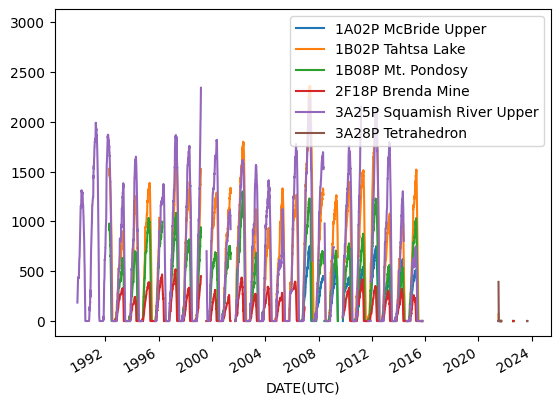

In [211]:
plt.close("all")
#Subset the data following the stations with hourly records
#dfsub1 = df[]
#Set the rows with hours != 16:00 to NaN
df.loc[df.index.strftime('%H').isin(['00','01','02','03','04','05','06','07','08','09','10','11',
        '12','13','14','15','17','18','19','20','21','22','23']),
        ['1A02P McBride Upper', '1B02P Tahtsa Lake', '1B08P Mt. Pondosy', '2F18P Brenda Mine', 
         '3A25P Squamish River Upper', '3A28P Tetrahedron']] = np.nan
df[['1A02P McBride Upper', '1B02P Tahtsa Lake', '1B08P Mt. Pondosy', '2F18P Brenda Mine', '3A25P Squamish River Upper', '3A28P Tetrahedron']].plot();


Additionally, the stations '4D16P Forrest Kerr Mid Elevation Snow', '4D17P Forrest Kerr High Elevation Snow' have data on the 00:00. These also appear not to have data on the 16:00. So, perhaps we can simply move those timestamps by the 16 hours to make them 

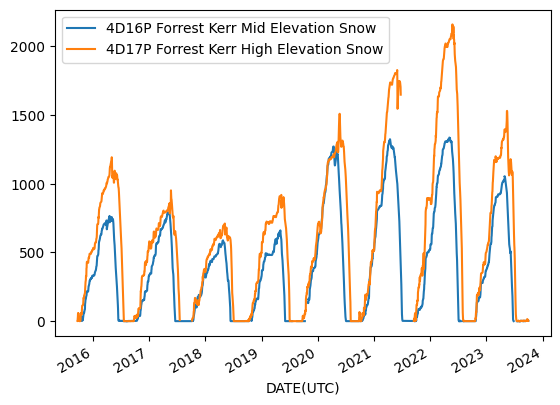

In [212]:
dfsub = df[['4D16P Forrest Kerr Mid Elevation Snow','4D17P Forrest Kerr High Elevation Snow']]
dfsub = dfsub.dropna(axis=0,how='all')
dfsub.index += pd.Timedelta("16 hours")
dfsub.plot();



Now simply merge the three data frames into a master data frame that only has the data we want. 


In [213]:
#Subset the 
dfsub2 = df.loc[:,~df.columns.isin(['4D16P Forrest Kerr Mid Elevation Snow','4D17P Forrest Kerr High Elevation Snow'])]
dfsub2.loc[dfsub2.index.strftime('%H') == '22',:] = np.nan
dfsub2 = dfsub2.dropna(axis=0,how='all')
dfsub2 = dfsub2.join(dfsub)
df = dfsub2.dropna(axis=0,how='all')
df.index.strftime('%H').unique()

/tmp/ipykernel_8613/1284653743.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Index(['16'], dtype='object', name='DATE(UTC)')

In [214]:
df['hydrodoy'] = df.index.strftime('%j').astype(int)
df['hydrodoy'] += -273
#df['hydrodoy']
df['hydrodoy'] = df['hydrodoy'].mask(df['hydrodoy']<1,df['hydrodoy']+365)

#sample plotting
#df.plot('hydrodoy','1A02P McBride Upper',xlabel='Hydrological Day of the Year',ylabel='Snow Water Equivalent (mm)')


Make a column formatted so that gives the hydrological year. Essentially the time index, forward by 3 months,
then reformatted to %Y using strftime.


In [215]:
def datetimepandas(timestamp):
    return datetime.strftime(timestamp,'%Y')
df['hydrological_year'] = df.index + pd.Timedelta("92 day")
df['hydrological_year'] = df['hydrological_year'].apply(datetimepandas)
#df['hydrological_year'] = df['hydrological_year'].astype(int)


<Axes: xlabel='Hydrological Day of the Year', ylabel='Snow Water Equivalent (mm)'>

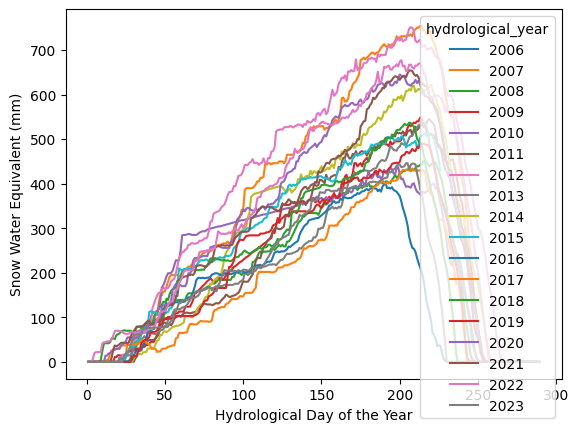

In [216]:

#index = pd.MultiIndex.from_frame(df[['hydrological_year','hydrodoy']])
subdf = df[['1A02P McBride Upper','hydrological_year','hydrodoy']]
subdf_pivoted = pd.pivot_table(subdf,index=["hydrodoy"],columns="hydrological_year",values="1A02P McBride Upper")

#Sample plotting
subdf_pivoted.loc[0:289,:].plot(xlabel='Hydrological Day of the Year', ylabel='Snow Water Equivalent (mm)')

Let's make a multi-year plot of the data for a given station along an axis that is the days of the water year.

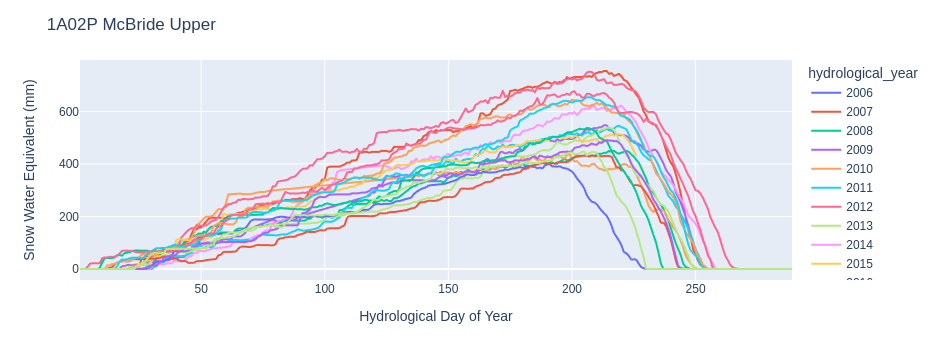

In [217]:
fig = px.line(subdf_pivoted.loc[0:289,:],)
fig.update_layout(title="1A02P McBride Upper",
                   xaxis_title="Hydrological Day of Year",
                   yaxis_title="Snow Water Equivalent (mm)")
fig.show()

In [218]:

#Melt the dataframe into a long format for plotting flexibility.
#meltdf = df.melt(var_name='Snow_Survey_Station',value_name='Snow_Amount', ignore_index=False)

#Get the min and max date and years
#mindate = min(df.index)
#minyear = datetime.strftime(mindate,'%Y')
#maxdate = max(df.index)
#maxyear = datetime.strftime(maxdate,'%Y')
#print (mindate,maxdate,minyear,maxyear)


Need to bring in the monthly ENSO data. We'll probably use the Oceanic Nino Index for this.
May want to alternatively or additionally bring in the monthly PNA and use some form of season-averaged PNA as
a stratifire for snow. Should be more directly applicable to snow pack as it covaries with ENSO/is driven by it.

In [264]:

#FIXME: Import oceanic Nino index and massage into a form that allows selection by ENSO strength

onidata = pd.read_fwf('https://www.cpc.ncep.noaa.gov/data/indices/oni.ascii.txt')
#Need to add a year to the OND and NDJ seasoned years to correspond to the hydrological year that ENSO cycle belongs to.
onidata['YR'] = onidata['YR'].mask(onidata['SEAS'].isin(['OND','NDJ']),onidata['YR']+1)
onirange = list([2,3])
yearsuse = onidata.loc[(onidata["ANOM"] >= onirange[0]) & 
    (onidata["ANOM"] <= onirange[1]) & 
    (onidata["SEAS"].isin(['OND','NDJ','DJF','JFM','FMA','MAM'])),'YR'].unique()
yearsuse.astype(str)[0:3]

array(['1973', '1983', '1998'], dtype='<U21')

## Build the app

Okay, the daily snow water equivalent data are munged into a form that is relatively clean and useful and we have the tools to stratify the data by year, hydrological day of the year and station. Time to build the app. We want a simple layout that has a snow station selector at the top along with an ENSO strength slider with La Nina max on the left and El Nino max on the right. Perhaps most ideal would be slider with two tabs that alows the picking of a max and a min ONI value. Will have to think about this... 

In [265]:
app = Dash(__name__)
app.layout = html.Div([
    html.H4('Multi-year Snow Water Equivalent Stratified by ENSO Strength'),
    dcc.Dropdown(
        df.columns[0:118],
        df.columns[60],
        id='snow-station-name',
        multi=False  #multi=True
    ),
    dcc.Graph(id="snow-station-graph"),
    dcc.RangeSlider(-3, 3, 0.5, value=[-0.5, 0.5], id='oni-range-slider')
])

#Now make a callback that uses the values from the drop down and the slider selection to stratify the 
#data and make the plot

@app.callback(
    Output("snow-station-graph", "figure"), 
    Input("oni-range-slider", "value"),
    Input("snow-station-name","value"))
def update_line_chart(onirange,stationname):
    subdf = df[[stationname,'hydrological_year','hydrodoy']]
    subdf_pivoted = pd.pivot_table(subdf,index=["hydrodoy"],columns="hydrological_year",values=stationname)
    yearsuse = onidata.loc[(onidata["ANOM"] >= onirange[0]) & 
        (onidata["ANOM"] <= onirange[1]) & 
        (onidata["SEAS"].isin(['OND','NDJ','DJF','JFM','FMA','MAM'])),'YR'].unique()
    
    fig = px.line(subdf_pivoted.loc[0:310,subdf_pivoted.columns.isin(yearsuse.astype(str))])
    fig.update_layout(title=stationname,
                   xaxis_title="Hydrological Day of Year",
                   yaxis_title="Snow Water Equivalent (mm)")
    #Strategy to get the plot to show only years of interest. 
    # 1) by default only show a shaded range between max and min with a line for median snow
    # 2) When the data are stratified by ENSO, add to the figure with attribute visible='legendonly'
    #    Like this: 
    #        fig.add_trace(go.Scatter(
    #            x=[1, 2, 3, 4, 5],
    #            y=[5, 4, 3, 2, 1],
    #            visible='legendonly'
    #        ))
    return fig

if __name__ == '__main__':
    app.run(debug=True,port=8049)